In [23]:
from orbax import checkpoint

In [1]:
import hydra
import wandb
from ott.neural import datasets
import sys
from omegaconf import DictConfig
import jax.numpy as jnp
from jax import random
from typing import Optional, Literal
import jax
import pathlib
import optax
import yaml
from datetime import datetime
from flax import linen as nn
import functools
from tqdm import tqdm
from flax.training import train_state

from ott.neural.networks.layers import time_encoder
from ott.neural.methods.flows import dynamics, otfm, genot
from ott.neural.networks import velocity_field
from ott.solvers import utils as solver_utils
import jax.tree_util as jtu
from ott.neural.networks.layers import time_encoder
from ott.neural.networks.velocity_field import VelocityField
import pandas as pd
import os

import hydra
from omegaconf import DictConfig, OmegaConf

from torch.utils.data import DataLoader
import numpy as np

import scanpy as sc
from ot_pert.metrics import compute_metrics_fast, compute_mean_metrics
from ot_pert.nets.nets import VelocityFieldWithAttention
from ot_pert.utils import ConditionalLoader


In [2]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add

In [3]:
obsm_key_cond = "ecfp_dose_cell_line"
obsm_key_data = "X_pca"

In [4]:
adata_train_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_30.h5ad"
adata_test_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_30.h5ad"
adata_ood_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_30.h5ad"

In [5]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
sc.pp.subsample(adata_train, fraction=0.1)

In [7]:
adata_train.obsm["ecfp_dose"] = np.concatenate(
    (adata_train.obsm["ecfp"], np.asarray(adata_train.obs["dose"])[:, None]), axis=1
)
adata_test.obsm["ecfp_dose"] = np.concatenate(
    (adata_test.obsm["ecfp"], np.asarray(adata_test.obs["dose"])[:, None]), axis=1
)
adata_ood.obsm["ecfp_dose"] = np.concatenate(
    (adata_ood.obsm["ecfp"], np.asarray(adata_ood.obs["dose"])[:, None]), axis=1
)

In [8]:
adata_train.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_train.obsm["ecfp_dose"], adata_train.obsm["cell_line_emb"]), axis=1
)
adata_test.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_test.obsm["ecfp_dose"], adata_test.obsm["cell_line_emb"]), axis=1
)
adata_ood.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_ood.obsm["ecfp_dose"], adata_ood.obsm["cell_line_emb"]), axis=1
)

In [9]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray], tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray], tgt_quad: Optional[jnp.ndarray], *,
    typ: Literal["lin", "quad", "fused"], epsilon: float = 1e-2, tau_a: float = 1.0,
    tau_b: float = 1.0,
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(x=src_lin, y=tgt_lin, scale_cost="mean", epsilon=epsilon, tau_a=tau_a, tau_b=tau_b)
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(
            xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin
        )
    raise NotImplementedError(f"Unknown type: {typ}.")

# Load data

dls = []

train_data_source = {}
train_data_target = {}
train_data_source_decoded = {}
train_data_target_decoded = {}
train_data_conditions = {}


for cond in adata_train.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_train[adata_train.obs["condition"]==cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_train[adata_train.obs["condition"]==src_str[0]+"_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_train[adata_train.obs["condition"]==src_str[0]+"_Vehicle_0.0"].X.A
    target = adata_train[adata_train.obs["condition"]==cond].obsm[obsm_key_data]
    target_decoded = adata_train[adata_train.obs["condition"]==cond].X.A
    conds = adata_train[adata_train.obs["condition"]==cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    dls.append(DataLoader(datasets.OTDataset(datasets.OTData(
        lin=source,
        condition=conds,
    ), datasets.OTData(lin=target)), batch_size=1024, shuffle=True))
    train_data_source[cond] = source
    train_data_target[cond] = target
    train_data_conditions[cond] = conds
    train_data_source_decoded[cond] = source_decoded
    train_data_target_decoded[cond] = target_decoded

train_loader = ConditionalLoader(dls, seed=0)

test_data_source = {}
test_data_target = {}
test_data_source_decoded = {}
test_data_target_decoded = {}
test_data_conditions = {}

for cond in adata_test.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_test[adata_test.obs["condition"]==cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_test[adata_test.obs["condition"]==src_str[0]+"_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_test[adata_test.obs["condition"]==src_str[0]+"_Vehicle_0.0"].X.A

    target = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_data]
    target_decoded = adata_test[adata_test.obs["condition"]==cond].X.A


    conds = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_source_decoded[cond] = source_decoded
    test_data_target_decoded[cond] = target_decoded
    test_data_conditions[cond] = conds

ood_data_source = {}
ood_data_target = {}
ood_data_source_decoded = {}
ood_data_target_decoded = {}
ood_data_conditions = {}

for cond in adata_ood.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_ood[adata_ood.obs["condition"]==cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_ood[adata_ood.obs["condition"]==src_str[0]+"_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_ood[adata_ood.obs["condition"]==src_str[0]+"_Vehicle_0.0"].X.A
    target = adata_ood[adata_ood.obs["condition"]==cond].obsm[obsm_key_data]
    target_decoded = adata_ood[adata_ood.obs["condition"]==cond].X.A
    conds = adata_ood[adata_ood.obs["condition"]==cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    ood_data_source[cond] = source
    ood_data_target[cond] = target
    ood_data_source_decoded[cond] = source_decoded
    ood_data_target_decoded[cond] = target_decoded
    ood_data_conditions[cond] = conds

reconstruct_data_fn = functools.partial(reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T)


2024-04-23 13:59:44.826100: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
reconstruct_data_fn = functools.partial(reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T)

train_deg_dict = {k: v for k,v in adata_train.uns['rank_genes_groups_cov_all'].items() if k in train_data_conditions.keys()}
test_deg_dict = {k: v for k,v in adata_train.uns['rank_genes_groups_cov_all'].items() if k in test_data_conditions.keys()}
ood_deg_dict = {k: v for k,v in adata_train.uns['rank_genes_groups_cov_all'].items() if k in ood_data_conditions.keys()}

def get_mask(x, y):
    return x[:, [gene in y for gene in adata_train.var_names]]

In [11]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

In [12]:
from typing import Callable, Optional, Sequence

import jax.numpy as jnp

from flax import linen as nn

from ott.neural.networks.layers import time_encoder

In [13]:
from typing import Dict, Tuple
def prepare_data(
        batch: Dict[str, jnp.ndarray]
    ) -> Tuple[Tuple[jnp.ndarray, Optional[jnp.ndarray], jnp.ndarray],
               Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray],
                     Optional[jnp.ndarray]]]:
      src_lin, src_quad = batch.get("src_lin"), batch.get("src_quad")
      tgt_lin, tgt_quad = batch.get("tgt_lin"), batch.get("tgt_quad")

      if src_quad is None and tgt_quad is None:  # lin
        src, tgt = src_lin, tgt_lin
        arrs = src_lin, tgt_lin
      elif src_lin is None and tgt_lin is None:  # quad
        src, tgt = src_quad, tgt_quad
        arrs = src_quad, tgt_quad
      elif all(
          arr is not None for arr in (src_lin, tgt_lin, src_quad, tgt_quad)
      ):  # fused quad
        src = jnp.concatenate([src_lin, src_quad], axis=1)
        tgt = jnp.concatenate([tgt_lin, tgt_quad], axis=1)
        arrs = src_quad, tgt_quad, src_lin, tgt_lin
      else:
        raise RuntimeError("Cannot infer OT problem type from data.")

      return (src, batch.get("src_condition"), tgt), arrs


In [14]:
vf = VelocityField(
    hidden_dims=[1024, 1024, 1024],
    time_dims=[512,512],
    output_dims=[1024, 1024, 1024]+[target_dim],
    condition_dims=[2048, 2048],
    time_encoder = functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
    )

model = genot.GENOT(
    vf,
    flow=dynamics.ConstantNoiseFlow(0.0),
    data_match_fn=jax.jit(functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None)),
    source_dim=source_dim,
    target_dim=target_dim,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20), )
training_logs = {"loss": []}

In [15]:
rng = jax.random.PRNGKey(0)
for it in tqdm(range(1000)):

    batch = next(iter(train_loader))
    batch = jtu.tree_map(jnp.asarray, batch)
    rng = jax.random.split(rng, 5)
    rng, rng_resample, rng_noise, rng_time, rng_step_fn = rng

    batch = jtu.tree_map(jnp.asarray, batch)
    (src, src_cond, tgt), matching_data = prepare_data(batch)

    n = src.shape[0]
    time = model.time_sampler(rng_time, n * model.n_samples_per_src)
    latent = model.latent_noise_fn(rng_noise, (n, model.n_samples_per_src))

    tmat = model.data_match_fn(*matching_data)  # (n, m)
    src_ixs, tgt_ixs = solver_utils.sample_conditional(  # (n, k), (m, k)
      rng_resample,
      tmat,
      k=model.n_samples_per_src,
    )

    src, tgt = src[src_ixs], tgt[tgt_ixs]  # (n, k, ...),  # (m, k, ...)
    if src_cond is not None:
        src_cond = src_cond[src_ixs]

    if model.latent_match_fn is not None:
        src, src_cond, tgt = model._match_latent(rng, src, src_cond, latent, tgt)

    src = src.reshape(-1, *src.shape[2:])  # (n * k, ...)
    tgt = tgt.reshape(-1, *tgt.shape[2:])  # (m * k, ...)
    latent = latent.reshape(-1, *latent.shape[2:])
    if src_cond is not None:
        src_cond = src_cond.reshape(-1, *src_cond.shape[2:])



    loss, model.vf_state = model.step_fn(
      rng_step_fn, model.vf_state, time, src, tgt, latent, src_cond
    )

    training_logs["loss"].append(float(loss))



100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


In [17]:
import orbax

In [24]:
checkpointer = orbax.Checkpointer(directory="checkpoints", prefix="model_checkpoint")


AttributeError: module 'orbax' has no attribute 'Checkpointer'

In [25]:
options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=10, create=True)
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
checkpoint_manager = orbax.checkpoint.CheckpointManager(".", orbax_checkpointer, options)

In [30]:
checkpointer_load = orbax.checkpoint.Checkpointer(directory=".", prefix="model_checkpoint")

TypeError: Checkpointer.__init__() got an unexpected keyword argument 'directory'

In [ ]:
model_state, step = checkpointer_load.restore_latest()

In [22]:
from orbax import checkpoint

In [32]:
checkpointer = ocp.StandardCheckpointer()

checkpointer.save( '/home/icb/dominik.klein/tmp/checkpoint_name', model.vf_state)


In [ ]:
checkpointer.restore(
    "/home/icb/dominik.klein/tmp/checkpoint_name",
    args=ocp.args.StandardRestore(abstract_my_tree)
)

In [29]:
print(dir(orbax))

['__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'checkpoint']


In [38]:
options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=10, create=True)
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
checkpoint_manager = orbax.checkpoint.CheckpointManager("/home/icb/dominik.klein/tmp/", orbax_checkpointer, options)

In [36]:
out_dir = "/home/icb/dominik.klein/tmp/"

In [37]:
path = ocp.test_utils.erase_and_create_empty(outdir)

AttributeError: module 'orbax.checkpoint.test_utils' has no attribute 'erase_and_create_empty'

In [39]:
checkpointer = ocp.StandardCheckpointer()

In [41]:
checkpointer.save(out_dir+"/tmp", model.vf_state)

In [47]:
checkpoint_manager = orbax.checkpoint.CheckpointManager(checkpoint_dir=out_dir, max_to_keep=5)

TypeError: CheckpointManager.__init__() got an unexpected keyword argument 'checkpoint_dir'

In [48]:
from orbax.checkpoint import CheckpointManager
import os

# Initialize the checkpoint manager
checkpoint_manager = CheckpointManager(checkpoint_dir=out_dir)

# Load the most recent checkpoint
checkpoint = checkpoint_manager.restore_latest()

# If a checkpoint was found and loaded
if checkpoint is not None:
    restored_vf_state = checkpoint['vf_state']
    # Assuming 'model' is your model instance and 'vf_state' is a property or attribute
    model.vf_state = restored_vf_state
    print("Model state restored successfully.")
else:
    print("No checkpoint found. Starting from scratch.")


TypeError: CheckpointManager.__init__() got an unexpected keyword argument 'checkpoint_dir'

In [52]:
checkpointer = orbax.checkpoint.PyTreeCheckpointer()
checkpointer.save(out_dir+"/tmp/tmp", model.vf_state)

In [53]:
checkpointer2 = orbax.checkpoint.PyTreeCheckpointer()
state = checkpointer2.restore(out_dir+"/tmp/tmp", item=model.vf_state)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/orbax/checkpoint/type_handlers.py:1475: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [ ]:
checkpointer.restore(
    out_dir+"/tmp",
    args=ocp.args.StandardRestore(model.vf_state2)
)

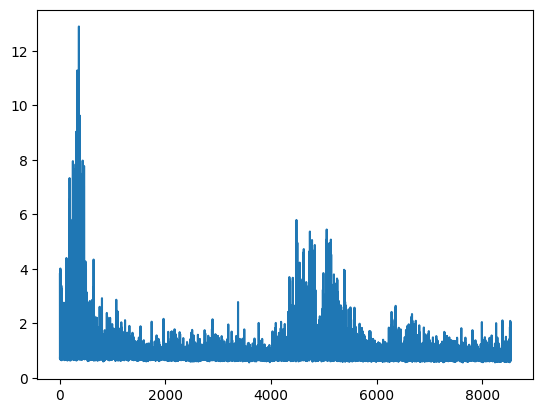

In [24]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(training_logs["loss"][10000:])), training_logs["loss"][10000:])

In [25]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
ood_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
)
mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

In [26]:
mean_ood_metrics_decoded

{'decoded_ood_r_squared': 0.9536295289511787,
 'decoded_ood_e_distance': 2.2383484574574974,
 'decoded_ood_mmd_distance': 0.05575790749466011}

In [28]:
ood_metrics

{'A549_A-366_10.0': {'r_squared': 0.988750883634964,
  'e_distance': 0.689524552861867,
  'mmd_distance': 0.00879505051122285},
 'A549_A-366_100.0': {'r_squared': 0.9955801809442499,
  'e_distance': 0.24552247339868494,
  'mmd_distance': 0.005803556220645091},
 'A549_A-366_10000.0': {'r_squared': 0.852262618114223,
  'e_distance': 8.2846604877384,
  'mmd_distance': 0.05139989404043497},
 'A549_Carmofur_10.0': {'r_squared': 0.990265990498614,
  'e_distance': 0.5802889401868825,
  'mmd_distance': 0.008087431469814105},
 'A549_Carmofur_100.0': {'r_squared': 0.9942623167640163,
  'e_distance': 0.3406466795675911,
  'mmd_distance': 0.005872124656406539},
 'A549_Disulfiram__10.0': {'r_squared': 0.99407125698334,
  'e_distance': 0.334014377948078,
  'mmd_distance': 0.006722748704250399},
 'A549_Disulfiram__1000.0': {'r_squared': 0.9929527329748723,
  'e_distance': 0.4326922752295701,
  'mmd_distance': 0.008836829684776096},
 'A549_Disulfiram__10000.0': {'r_squared': 0.8496479756522815,
  'e_d

In [19]:
[k:]

{'decoded_ood_r_squared': -0.7164179366485877,
 'decoded_ood_e_distance': 52.26967538874433,
 'decoded_ood_mmd_distance': 0.13167360613726622}

In [1]:
1

1

In [1]:
ood_metrics_decoded

NameError: name 'ood_metrics_decoded' is not defined

In [15]:
len([el for el in test_data_source.keys() if el.startswith("K562")])

353

In [16]:
len([el for el in test_data_source.keys() if el.startswith("MCF7")])

619

In [17]:
len([el for el in test_data_source.keys() if el.startswith("A549")])

303